In [1]:
%load_ext autoreload
%autoreload 1
from PIL import Image, ImageDraw
import torch
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from object_detection_data import Encoder
from pytorch_lightning.callbacks import RichProgressBar
import pytorch_lightning as pl

%aimport 
from object_detection_models import MultiClassJetNet


Modules to reload:


Modules to skip:



In [5]:
class SyntheticData(DataLoader):
    def __init__(self, image_width, image_height, length, encoder):
        self.image_width = image_width
        self.image_height = image_height
        self.length = length
        self.encoder = encoder

        self.images = []
        self.encoded_bounding_boxes = []
        self.encoded_target_classes = []
        self.target_masks = []
        for _ in range(length):
            image, bounding_box = self._generate_image()
            encoded_bounding_boxes, target_mask, target_classes = self.encoder.apply(
                bounding_box, torch.tensor([[1]])
            )
            self.images.append(image)
            self.encoded_bounding_boxes.append(encoded_bounding_boxes)
            self.encoded_target_classes.append(target_classes)
            self.target_masks.append(target_mask)

    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.encoded_bounding_boxes[idx],
            self.target_masks[idx],
            self.encoded_target_classes[idx],
        )

    def __len__(self) -> int:
        return self.length

    def _generate_image(self):
        image = Image.new("1", (image_width, image_height))
        image_draw = ImageDraw.Draw(image)
        center = torch.tensor(
            [
                torch.randint(0, image_width - 1, (1,)).item(),
                torch.randint(0, image_height - 1, (1,)).item(),
            ]
        )
        size = torch.tensor([image_width * 0.25, image_height * 0.25])
        upper_left = center - size / 2
        lower_right = center + size / 2
        image_draw.rectangle(
            [upper_left[0], upper_left[1], lower_right[0], lower_right[1]], fill=255
        )
        bounding_box = torch.tensor(
            [
                [
                    center[0].item() / image_width,
                    center[1].item() / image_height,
                    size[0].item() / image_width,
                    size[1].item() / image_height,
                ]
            ]
        )
        return T.pil_to_tensor(image).to(torch.float), bounding_box


image_width = 80
image_height = 60
torch.manual_seed(2)

default_scalings = torch.tensor([[0.25, 0.25]])
num_classes = 1
encoder = Encoder(default_scalings, num_classes)

data = SyntheticData(image_width, image_height, 10000, encoder)
data_loader = DataLoader(data, batch_size=64, shuffle=False, drop_last=True)


In [4]:
from pytorch_lightning import loggers as pl_loggers

tb_logger = pl_loggers.TensorBoardLogger(save_dir="synthetic_data_logs/")


pl_model = MultiClassJetNet(encoder, 1e-3)
trainer = pl.Trainer(
    limit_predict_batches=100, max_epochs=60, callbacks=[RichProgressBar()], logger = tb_logger
)
trainer.fit(model=pl_model, train_dataloaders=data_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jonathan/hulks/ml/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ accuracy            │ MulticlassAccuracy │      0 │
│ 1 │ input_layer         │ NormConv2dReLU     │    146 │
│ 2 │ depth_wise_backbone │ Sequential         │  4.9 K │
│ 3 │ classifier          │ Sequential         │ 20.9 K │
│ 4 │ output_layer        │ Conv2d             │    150 │
└───┴─────────────────────┴────────────────────┴────────┘

Trainable params: 26.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.1 K                                                                                               
Total estimated model params size (MB): 0

/home/jonathan/hulks/ml/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Output()

`Trainer.fit` stopped: `max_epochs=60` reached.


In [100]:
import torch.nn.functional as F
from object_detection_data import calc_iou_tensor


def xywh_to_tlbr(xywh_bounding_boxes):
    # bounding boxes in format (batch, 4) (cx, cy, w, h)
    tlbr_bounding_boxes = torch.zeros_like(xywh_bounding_boxes)
    tlbr_bounding_boxes[:, 0:2] = (
        xywh_bounding_boxes[:, 0:2] - xywh_bounding_boxes[:, 2:4] / 2
    )

    tlbr_bounding_boxes[:, 2:4] = (
        xywh_bounding_boxes[:, 0:2] + xywh_bounding_boxes[:, 2:4] / 2
    )
    return tlbr_bounding_boxes


def decode_model_output(encoder, predicted_boxes):
    decoded_boxes = torch.zeros(predicted_boxes.shape)
    decoded_boxes[:, :, 0:2] = encoder.default_boxes_xy_wh[:, 2:4] * (
        encoder.default_boxes_xy_wh[:, 0:2] - predicted_boxes[:, :, 0:2]
    )
    decoded_boxes[:, :, 2:4] = encoder.default_boxes_xy_wh[:, 2:4] * torch.exp(
        predicted_boxes[:, :, 2:4]
    )
    # decoded_boxes = decoded_boxes.squeeze()
    return decoded_boxes


# Raw model output
# -> Filter detected objects
# -> Calculate overlap of prediceted bounding boxes with groundtruth bounding boxes
# -> Filter all boxes that meet a threshold
# -> Calculate precision
pl_model = MultiClassJetNet(encoder, 1e-3)
for batch in data_loader:
    image, target_boxes, target_masks, target_classes = batch
    predicted_boxes, predicted_class_logits = pl_model(image)
    class_probabilities = F.softmax(predicted_class_logits, dim=-1)
    decoded_boxes = decode_model_output(encoder, predicted_boxes).reshape((-1, 4))
    detection_mask = torch.argmax(class_probabilities, dim=-1) > 0
    # (cx, cy, w, h) -> (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
    object_boxes_tlbr = xywh_to_tlbr(decoded_boxes[detection_mask])
    target_boxes_tlbr = xywh_to_tlbr(target_boxes[target_masks])
    ious = calc_iou_tensor(object_boxes_tlbr, target_boxes_tlbr)
    break
ious[0] > 0.5

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [58]:
predicted_class_logits.shape

torch.Size([5120, 2])

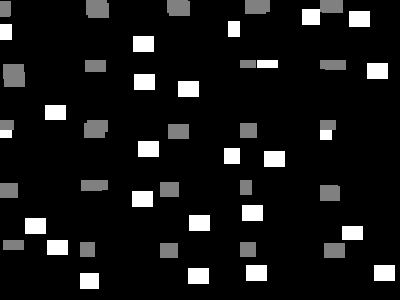

In [66]:
%aimport visualize
from visualize import draw_model_output, image_grid

grid_size = 5
image_list = []
for i in range(grid_size * grid_size):
    image, encoded_bounding_boxes, target_masks, encoded_target_classes, idx = data[i]
    predicted_boxes, predicted_class_logits = pl_model(image.unsqueeze(0))
    image_list.append(
        draw_model_output(
            image,
            predicted_boxes,
            predicted_class_logits,
            torch.tensor([0, 1]),
            encoder,
        )
    )
image_grid(image_list, grid_size, grid_size)
